На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

* В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
* Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

## Задания:
1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выберите формулу для модели, проведите тест.

## Описание данных
`5_task_1:`

* id – id клиента в эксперименте
* group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
* events – сколько блюд суммарно было заказано за период

`5_task_2:`

* id – id клиента в эксперименте
* segment – сегмент (high/low)
* group – вид кнопки (control – старая версия, test – новая версия)
* events – сколько блюд суммарно было заказано за период

# Задание 1

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9

B – квадратные

C – прямоугольные 12:4

Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

* t-test
* сделаю вывод исключительно по графику
* **ANOVA**
* посчитаю хи-квадрат

# Задание 2

Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

Hint: scipy.stats.levene либо pingouin.homoscedasticity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

In [2]:
task_1 = pd.read_csv('5_task_1.csv')
task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


Не отклоняем нулевую гипотезу (p-value > 0.05) 
Гомогенность есть

In [9]:
scipy.stats.levene(task_1.query('group == "A"').events,task_1.query('group == "B"').events,task_1.query('group == "C"').events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

 Все три распределены нормально (p-value > 0.05)

In [16]:
scipy.stats.shapiro(task_1.query('group == "A"').events.sample(1000, random_state=17))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [17]:
scipy.stats.shapiro(task_1.query('group == "B"').events.sample(1000, random_state=17))

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [18]:
scipy.stats.shapiro(task_1.query('group == "C"').events.sample(1000, random_state=17))

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

 Различия значимые:

In [21]:
scipy.stats.f_oneway(task_1.query("group == 'A'").events, 
                     task_1.query("group == 'B'").events, 
                     task_1.query("group == 'C'").events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

 Критерий Тьюки (различия в средних между всеми)

In [25]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

pairwise_tukeyhsd(task_1.events, task_1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,-0.0,7.7038,8.3642,True
A,C,-2.1093,-0.0,-2.4395,-1.7791,True
B,C,-10.1433,-0.0,-10.4735,-9.8131,True


In [28]:
from pingouin import pairwise_tukey 
pairwise_tukey(data=task_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


 Выбираем в таком случае вариант В (по количеству events)

In [29]:
task_1.groupby('group', as_index=False).agg({'events' : 'sum'})

,group,events
0,A,295796
1,B,376136
2,C,274703


In [3]:
task_2 = pd.read_csv('5_task_2.csv')
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [12]:
scipy.stats.levene(task_2.query('group == "test"').events,task_2.query('group == "control"').events)

LeveneResult(statistic=2.5440050816535327, pvalue=0.11071679229795423)

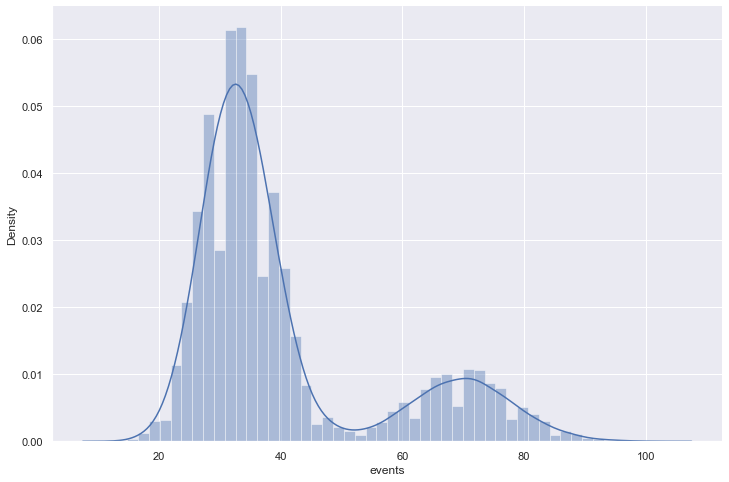

In [37]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(task_2.query("group == 'test'").events)
sns.despine()

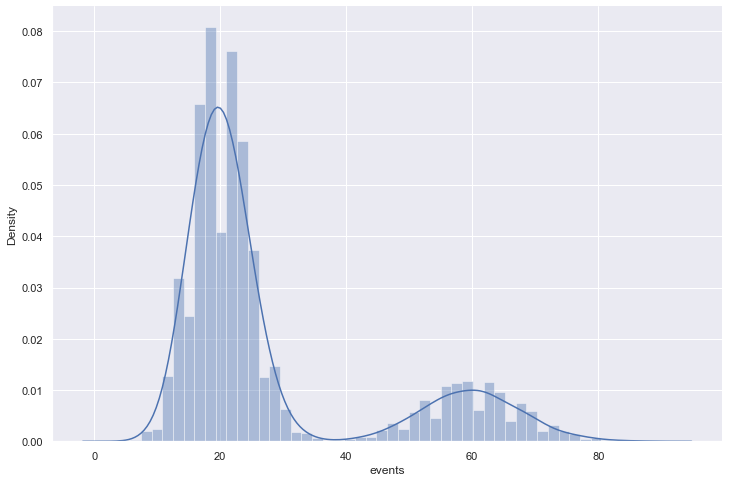

In [38]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(task_2.query("group == 'control'").events)
sns.despine()

In [39]:
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [45]:
print(task_2.query("group == 'control' & segment == 'high'").mean())
print(task_2.query("group == 'control' & segment == 'high'").std())
print(task_2.query("group == 'control' & segment == 'high'").median())
print('########################')
print(task_2.query("group == 'control' & segment == 'low'").mean())
print(task_2.query("group == 'control' & segment == 'low'").std())
print(task_2.query("group == 'control' & segment == 'low'").median())



id        50473.9782
events       59.9708
dtype: float64
id        28761.438914
events        7.805347
dtype: float64
id        51031.0
events       60.0
dtype: float64
########################
id        49935.256700
events       20.031575
dtype: float64
id        28855.849243
events        4.473576
dtype: float64
id        49944.5
events       20.0
dtype: float64


In [46]:
print('########################')
print(task_2.query("group == 'test' & segment == 'high'").mean())
print(task_2.query("group == 'test' & segment == 'high'").std())
print(task_2.query("group == 'test' & segment == 'high'").median())
print('########################')
print(task_2.query("group == 'test' & segment == 'low'").mean())
print(task_2.query("group == 'test' & segment == 'low'").std())
print(task_2.query("group == 'test' & segment == 'low'").median())

########################
id        50126.6206
events       69.9385
dtype: float64
id        28821.133487
events        8.403974
dtype: float64
id        50234.5
events       70.0
dtype: float64
########################
id        49913.343600
events       33.025925
dtype: float64
id        28917.383492
events        5.720845
dtype: float64
id        49706.5
events       33.0
dtype: float64


In [47]:
task_2['combination'] = task_2['group'] + ' \ ' + task_2['segment']
task_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high


## Тест 

In [48]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = 'events ~ group + segment + group:segment'
model = ols(formula, task_2).fit()
aov_table = anova_lm(model, typ=2)

In [49]:
aov_table

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


## Тьюки


In [58]:
pairwise_tukeyhsd(task_2.events, task_2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,-0.0,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,-0.0,9.7551,10.1803,True
control \ high,test \ low,-26.9449,-0.0,-27.113,-26.7768,True
control \ low,test \ high,49.9069,-0.0,49.7388,50.075,True
control \ low,test \ low,12.9944,-0.0,12.888,13.1007,True
test \ high,test \ low,-36.9126,-0.0,-37.0807,-36.7445,True


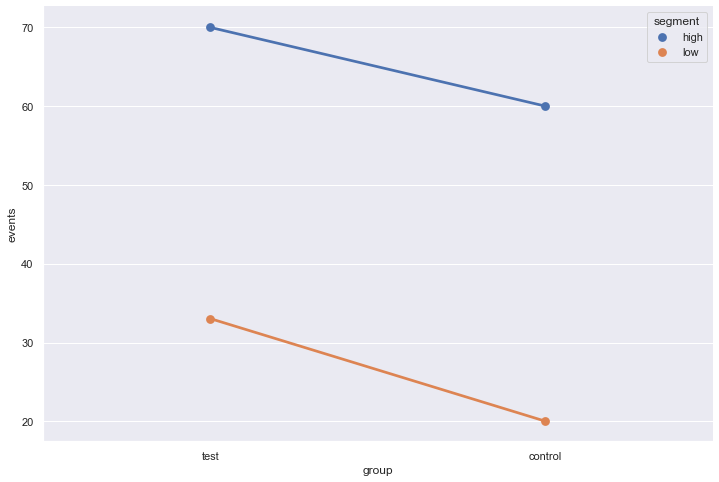

In [59]:
sns.pointplot(x='group' , y='events' , data=task_2, hue='segment')
sns.despine()

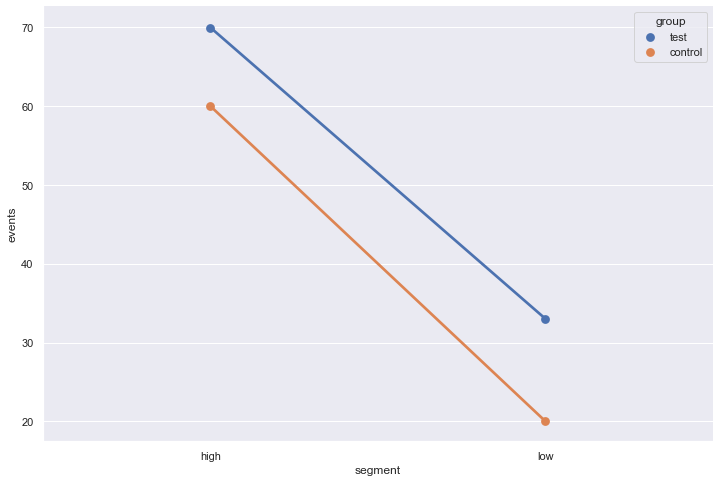

In [60]:
sns.pointplot(x='segment' , y='events' , data=task_2, hue='group')
sns.despine()

## Фактор group оказался `ЗНАЧИМЫМ`, фактор segment – `ЗНАЧИМЫМ`, их взаимодействие – `ЗНАЧИМО`. 
## Судя по графику, для всех групп среднее значение events `УВЕЛИЧИЛОСЬ`, поэтому решение: `ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ`